In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
import tensorflow_datasets as tfds
from keras.models import Model, Sequential
from keras.layers import Dense, Input
from keras.layers import Dropout
from keras.layers import BatchNormalization, Reshape, Conv2DTranspose, Conv2D, Flatten
from keras.layers import LeakyReLU
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import time


In [2]:
Z_DIM = 100
BATCH_SIZE = 1024
EPOCHS = 1


def generate_z(size):
    return tf.random.uniform((size, Z_DIM), -1, 1)



In [3]:
ds = tfds.load("quickdraw_bitmap", split="train", shuffle_files=True, data_dir="/mnt/external/tensorflow_datasets/")
assert isinstance(ds, tf.data.Dataset)
ds = ds.map(lambda x: (tf.cast(x["image"], tf.float32) - 127.5) / 127.5)

In [4]:
def create_generator():
    generator = Sequential()
    generator.add(Dense(units=256 * 7 * 7, input_dim=Z_DIM, use_bias=False))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU())
    generator.add(Reshape((7, 7, 256)))
    generator.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding="same", use_bias=False))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU())
    generator.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU())
    generator.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding="same", use_bias=False, activation="tanh"))
    generator.compile()

    return generator


g = create_generator()
g.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [5]:
def create_discriminator():
    discriminator = Sequential()
    discriminator.add(Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=[28, 28, 1]))
    discriminator.add(LeakyReLU())
    discriminator.add(Dropout(0.3))
    discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    discriminator.add(LeakyReLU())
    discriminator.add(Dropout(0.3))
    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation="sigmoid"))
    discriminator.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return discriminator


d = create_discriminator()
d.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [6]:
def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape=(Z_DIM,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return gan


gan = create_gan(d, g)
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         2330944   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 2,543,809
Trainable params: 2,305,472
Non-trainable params: 238,337
_________________________________________________________________


In [7]:
def plot_generated_images(generator):
    noise = generate_z(10)
    generated_images = generator.predict(noise, verbose=0)
    generated_images = generated_images.reshape(10, 28, 28)
    plt.figure(figsize=(10, 1))
    for i in range(generated_images.shape[0]):
        plt.subplot(1, 10, i + 1)
        plt.imshow(generated_images[i], interpolation="nearest", cmap="gray")
        plt.axis("off")
    plt.tight_layout()
    plt.show()



  0%|          | 0/49245 [00:00<?, ? batches/s]

2023-08-20 00:53:20.333794: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-08-20 00:53:23.185085: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


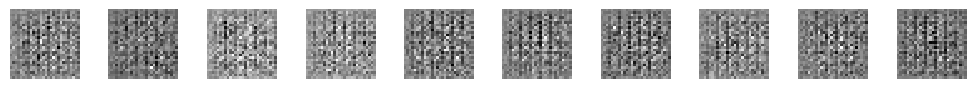

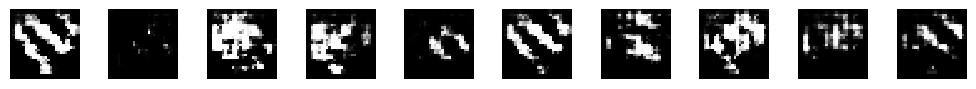

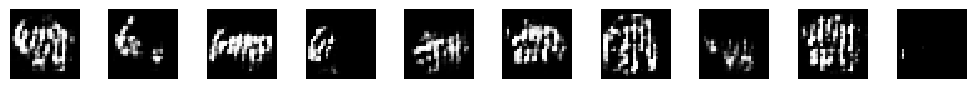

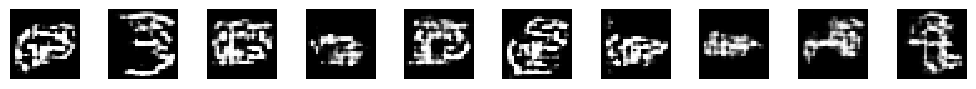

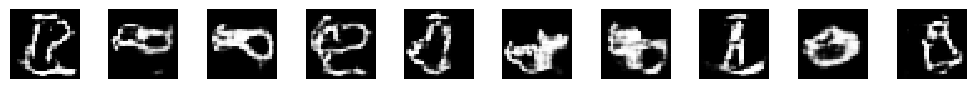

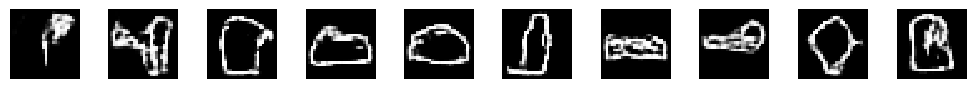

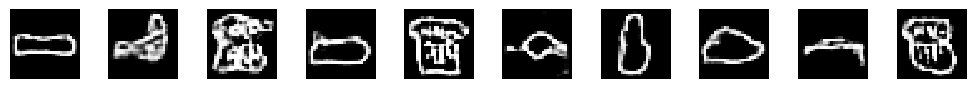

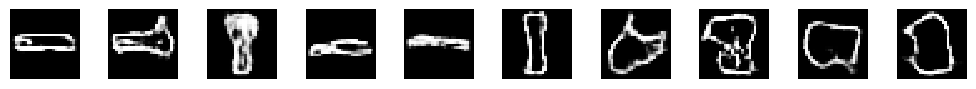

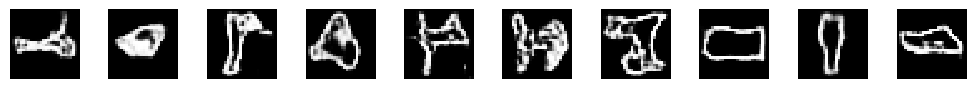

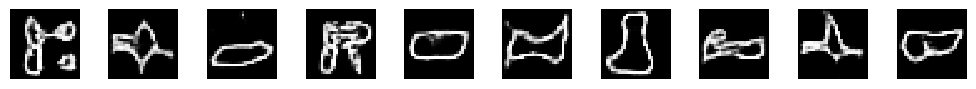

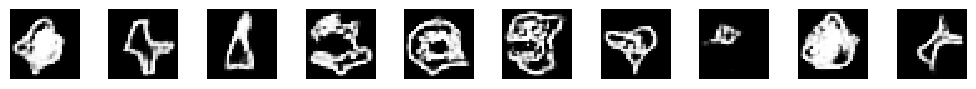

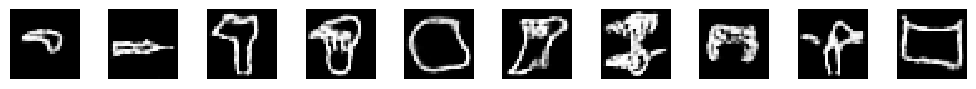

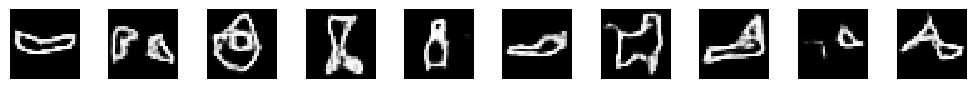

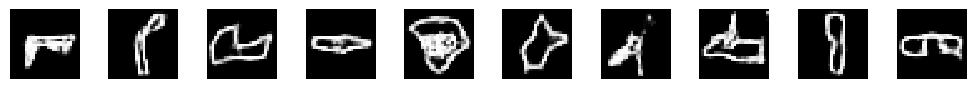

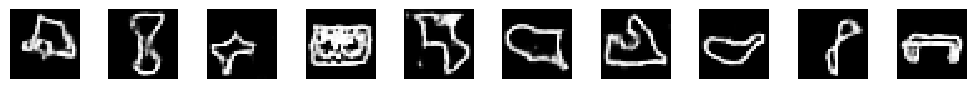

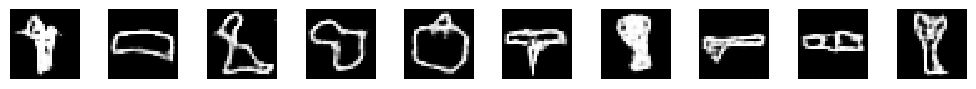

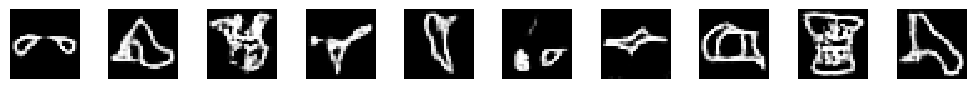

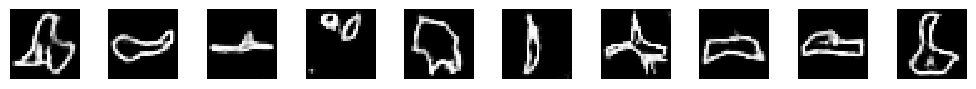

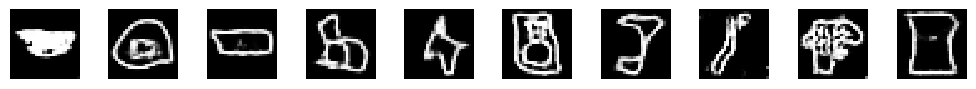

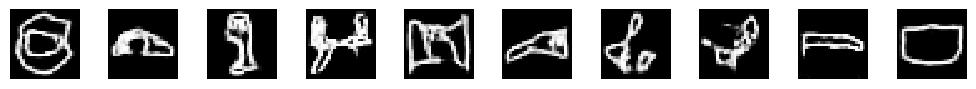

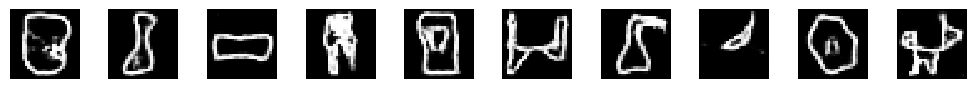

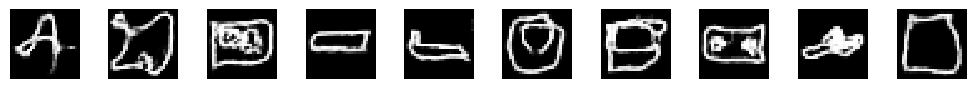

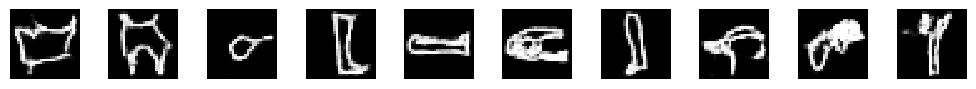

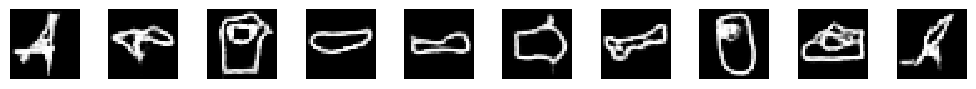

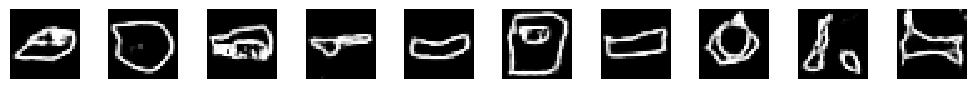

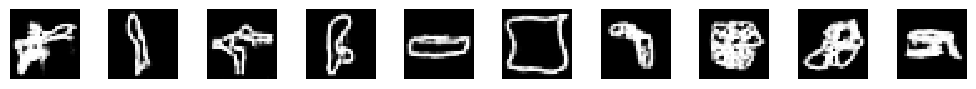

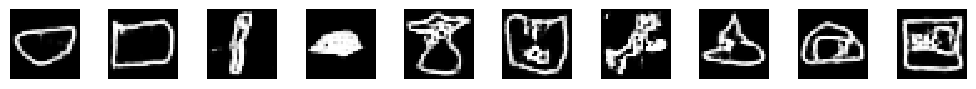

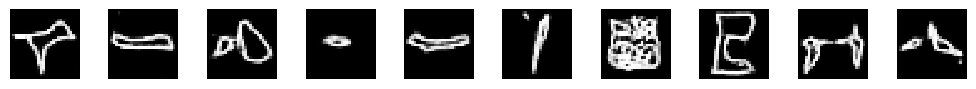

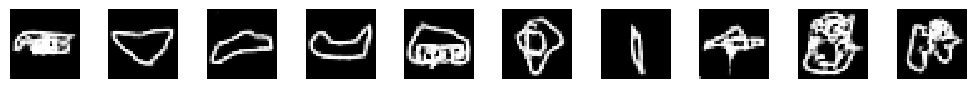

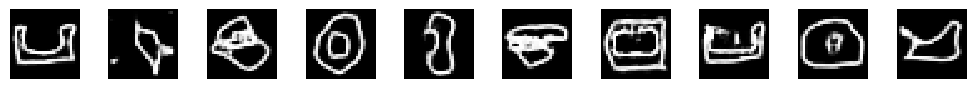

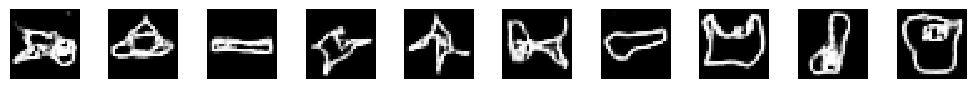

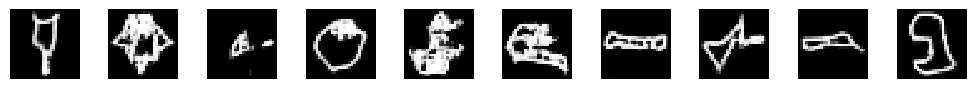

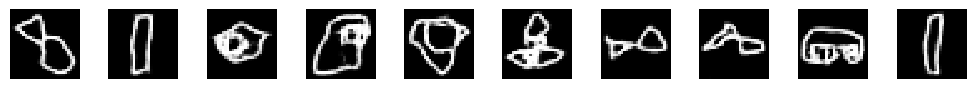

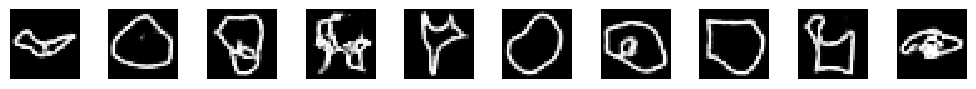

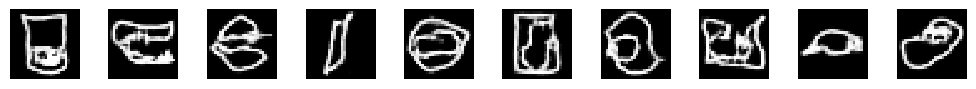

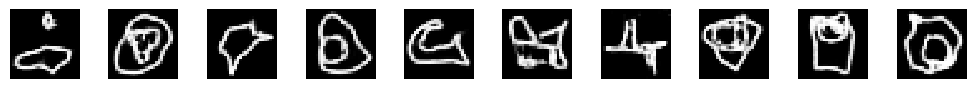

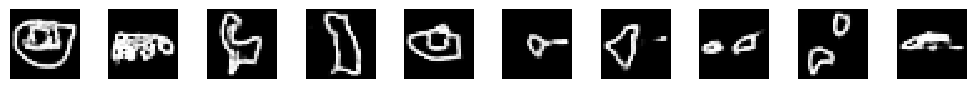

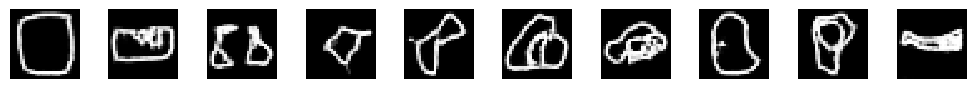

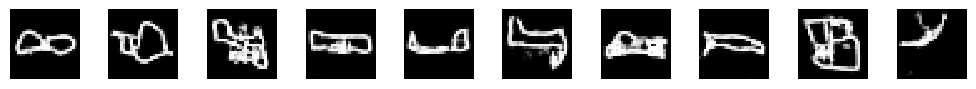

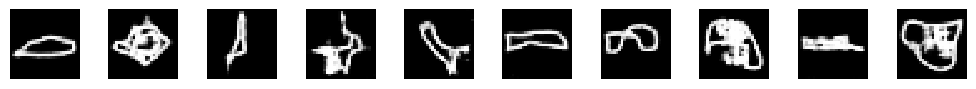

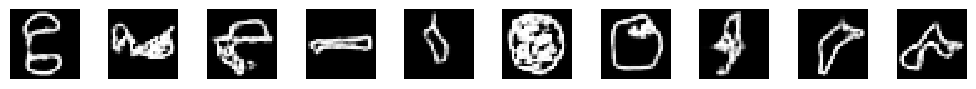

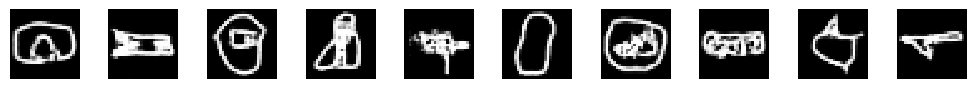

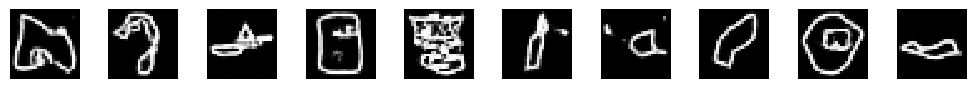

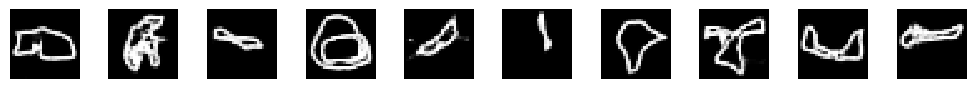

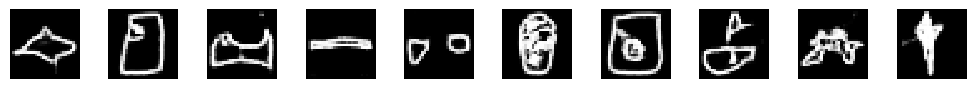

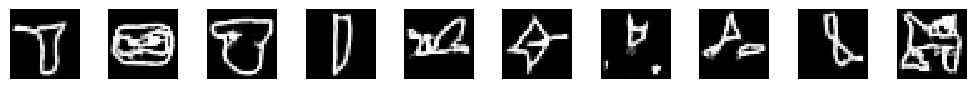

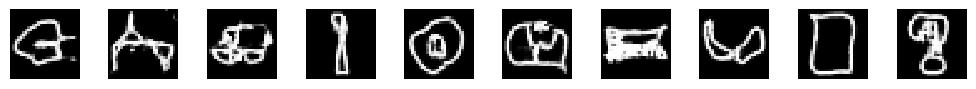

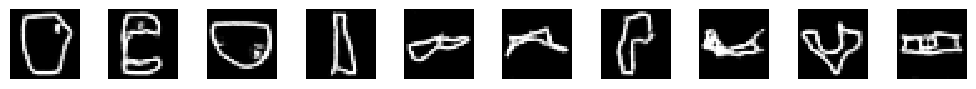

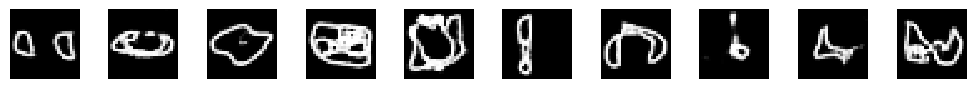

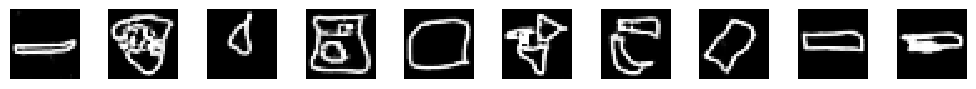

2023-08-20 04:30:09.660873: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-08-20 04:30:11.095163: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


In [8]:
dlosses = []
glosses = []

for epoch in range(EPOCHS):
    dloss = []
    gloss = []
    bar = tqdm.notebook.tqdm_notebook(ds.batch(BATCH_SIZE), unit=" batches")
    for i, batch in enumerate(bar):
        batch_size = batch.shape[0]
        noise = generate_z(batch_size)
        generated_images = g.predict(noise, verbose=0)
        X = tf.concat([batch, generated_images], axis=0)
        y_dis = tf.concat([tf.ones(batch_size, dtype=tf.float32), tf.zeros(batch_size, dtype=tf.float32)], axis=0)

        d.trainable = True

        dloss.append(d.train_on_batch(X, y_dis))

        noise = generate_z(batch_size)
        y_gen = tf.ones(batch_size, dtype=tf.float32)
        d.trainable = False
        gloss.append(gan.train_on_batch(noise, y_gen))

        bar.set_description(f"Discriminator Loss: {np.mean(dloss):.4f} Generator Loss: {np.mean(gloss):.4f}")
        if i % 10 == 0:
            dlosses.append(np.mean(dloss))
            glosses.append(np.mean(gloss))
            dloss = []
            gloss = []
        if i % 1000 == 0:
            plot_generated_images(g)

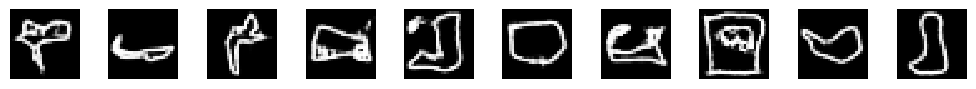

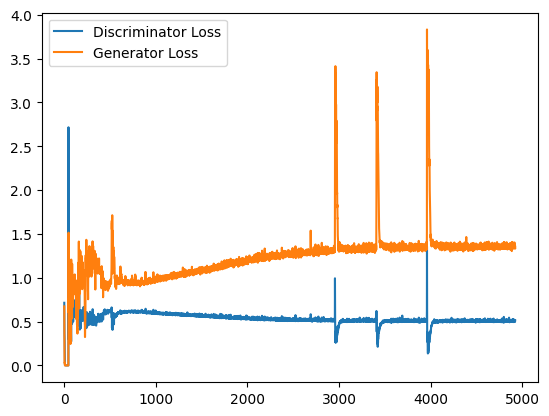

In [9]:
plot_generated_images(g)

plt.plot(dlosses, label="Discriminator Loss")
plt.plot(glosses, label="Generator Loss")
plt.legend()
plt.show()

In [10]:
g.save("generator.h5")
d.save("discriminator.h5")
gan.save("gan.h5")
